# Regularization, Stability, Model Selection & Evaluation

In [1]:
import numpy as np
from keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [9]:
from sklearn.model_selection import KFold

def cross_validation_error(X, y, model, folds):
    avg_train_error, avg_test_error = 0, 0
    for train_idx, valid_idx in KFold(n_splits=folds, shuffle=True).split(X):
        fitted_model = model.fit(X[train_idx], y[train_idx])
        train_pred = fitted_model.predict(X[train_idx])
        test_pred = fitted_model.predict(X[valid_idx])
        avg_train_error += np.mean(train_pred != y[train_idx])
        avg_test_error += np.mean(test_pred != y[valid_idx])
    
    return [avg_train_error / folds, avg_test_error / folds]
        

## Hyper parameter optimizer:

In [4]:
from sklearn.svm import SVC

def SVM_results(X_train, y_train, X_test, y_test):
    k = 5
    results = dict()
    degrees = [2, 4, 6, 8, 10]
    gammas = [0.001,0.01,0.1,1,10]

    # Linear:
    linear_model = SVC(kernel='linear')
    test_error = np.mean(y_test != linear_model.fit(X_train, y_train).predict(X_test))
    results['svm_linear'] = cross_validation_error(X_train, y_train, linear_model, k) + [test_error]

    # Polynomial:
    for degree in degrees:
        model = SVC(kernel='poly', degree=degree)
        test_error = np.mean(y_test != model.fit(X_train, y_train).predict(X_test))
        results[f"svm_poly_degree_{degree}"] = cross_validation_error(X_train,
                                                                        y_train, 
                                                                        model, 
                                                                        k) + [test_error]
    
    # RBF:
    for gamma in gammas:
        model = SVC(kernel='rbf', gamma=gamma)
        test_error = np.mean(y_test != model.fit(X_train, y_train).predict(X_test))
        results[f"svm_rbf_gamma_{gamma}"] = cross_validation_error(X_train,
                                                                        y_train, 
                                                                        model, 
                                                                        k) + [test_error]
    
    return results


## Gotta train 'em all!

In [5]:
from sklearn.model_selection import train_test_split

def load_mnist():
    np.random.seed(2)
    (X, y), (_, _) = mnist.load_data()
    indexes = np.random.choice(len(X), 8000, replace=False)
    X = X[indexes]
    y = y[indexes]
    X = X.reshape(len(X), -1)
    return X, y

X, y = load_mnist()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, train_size = 0.8)

from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler((-1,1),)
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [6]:
svm_res = SVM_results(X_train, y_train, X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

## Models Error-rate:

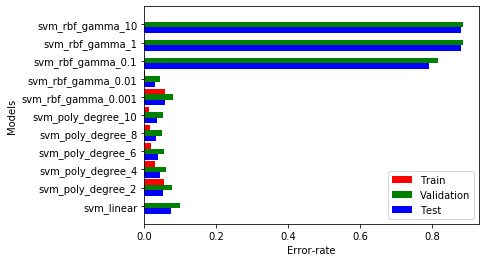

In [7]:

ind = np.arange(len(svm_res))
width = 0.3

plt.barh(ind, [res[0] for res in svm_res.values()], width, color= 'r', label='Train')
plt.barh(ind - width, [res[1] for res in svm_res.values()], width, color= 'g', label='Validation')
plt.barh(ind - 2 * width, [res[2] for res in svm_res.values()], width, color= 'b', label='Test')
plt.legend()
plt.xlabel("Error-rate")
plt.ylabel("Models")
plt.yticks(ind - width, svm_res.keys())
plt.show()

We can see that the best Test score was obtained with RBF, with gamma set to `0.01`.

Since the model also obtained to best Validation score (from Cross-Validation), we could predict that this is the best model, also for test-set.

## Evalulation :

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

class_to_val = {'setosa' : 0, 
                'versicolor' : 1, 
                'virginica' : 2 }

def adjust_labels_to_binary(y_train, target_class_value):
    return np.vectorize(lambda label: 1 if label==class_to_val[target_class_value] else -1)(y_train)

def one_vs_rest(X_train, y_train, target_class_value):
    y_train_binarized = adjust_labels_to_binary(y_train, target_class_value)
    return LogisticRegression(solver='liblinear').fit(X_train, y_train_binarized)

def binarized_confusion_matrix(X, y_binarized, one_vs_rest_model, prob_threshold):
    pred_proba = one_vs_rest_model.predict_proba(X)[:,1]
    y_pred = np.where(pred_proba > prob_threshold, 1, -1)
    TP = np.logical_and(y_pred == 1, y_binarized == 1).sum()
    FP = np.logical_and(y_pred == 1, y_binarized == -1).sum()
    FN = np.logical_and(y_pred == -1, y_binarized == 1).sum()
    TN = np.logical_and(y_pred == -1, y_binarized == -1).sum()

    return np.array([[TP, FP], [FN, TN]])
    


In [3]:
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, train_size = 0.7)

def get_class_cf(X_train, y_train, target_class_value, **kwargs):
    ovr_model = one_vs_rest(X_train, y_train, target_class_value)
    X_test = kwargs.get('X_test', X_train)
    y_test = kwargs.get('y_test', y_train)
    y_binarized = adjust_labels_to_binary(y_test, target_class_value)
    
    return binarized_confusion_matrix(X_test, y_binarized, ovr_model, prob_threshold=0.5)

models_cf = {iris_species : {
                    'train' : get_class_cf(X_train, y_train, iris_species), 
                    'test' : get_class_cf(X_train, y_train, iris_species, X_test= X_test, y_test= y_test)
                    } for iris_species in class_to_val.keys()}



## Confusion Matrices, much confusing:

In [4]:
for species, container in models_cf.items():
    print(f"{species}:")
    for step, cf in container.items():
        print(f"\t{step}: \n\t\t{cf[0]}\n\t\t{cf[1]}")
    print('-'*24)

setosa:
	train: 
		[39  0]
		[ 0 66]
	test: 
		[11  0]
		[ 0 34]
------------------------
versicolor:
	train: 
		[2 8]
		[29 66]
	test: 
		[3 1]
		[16 25]
------------------------
virginica:
	train: 
		[35  1]
		[ 0 69]
	test: 
		[15  3]
		[ 0 27]
------------------------


## Micro measurments:

In [5]:
all_targeted_class_dict = {iris_species : one_vs_rest(X_train, y_train, iris_species) 
                                                    for iris_species in class_to_val.keys()}


def micro_avg_precision(X, y, all_targeted_class_dict, prob_threshold):
    TP = 0
    FP = 0
    for species, ovr_model in all_targeted_class_dict.items():
        y_binarized = adjust_labels_to_binary(y, species)
        cf = binarized_confusion_matrix(X, y_binarized, ovr_model, prob_threshold)
        TP += cf[0,0]
        FP += cf[0,1]
    
    return (TP / (TP + FP))

def micro_avg_recall(X, y, all_targeted_class_dict, prob_threshold):
    TP = 0
    FN = 0
    for species, ovr_model in all_targeted_class_dict.items():
        y_binarized = adjust_labels_to_binary(y, species)
        cf = binarized_confusion_matrix(X, y_binarized, ovr_model, prob_threshold)
        TP += cf[0,0]
        FN += cf[1,0]
    
    return (TP / (TP + FN))

def micro_avg_false_positive_rate(X, y, all_targeted_class_dict, prob_threshold):
    FP = 0
    TN = 0
    for species, ovr_model in all_targeted_class_dict.items():
        y_binarized = adjust_labels_to_binary(y, species)
        cf = binarized_confusion_matrix(X, y_binarized, ovr_model, prob_threshold)
        FP += cf[0,1]
        TN += cf[1,1]
    
    return (FP / (FP + TN))


## ROC-Curve:

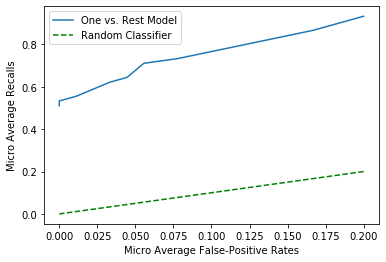

In [6]:
micro_avg_recalls = []
micro_avg_fp_rates = []
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for threshold in thresholds:
    micro_avg_recalls.append(
        micro_avg_recall(X_test, y_test, all_targeted_class_dict, threshold))
    micro_avg_fp_rates.append(
        micro_avg_false_positive_rate(X_test, y_test, all_targeted_class_dict, threshold))

plt.plot(micro_avg_fp_rates, micro_avg_recalls, label='One vs. Rest Model')
plt.plot(micro_avg_fp_rates, micro_avg_fp_rates, 'g--', label='Random Classifier')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend()
plt.xlabel('Micro Average False-Positive Rates')
plt.ylabel('Micro Average Recalls')
plt.show()

Note, the above ROC-curve doesn't contain edge threshold values of `0.0` and `1.0`, which results in a skewed axes.
The following ROC-curve is a traditional one:

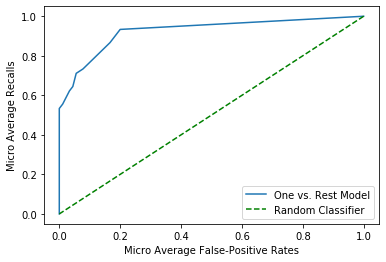

In [7]:
micro_avg_recalls = []
micro_avg_fp_rates = []
thresholds = [0, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 1]

for threshold in thresholds:
    micro_avg_recalls.append(
        micro_avg_recall(X_test, y_test, all_targeted_class_dict, threshold))
    micro_avg_fp_rates.append(
        micro_avg_false_positive_rate(X_test, y_test, all_targeted_class_dict, threshold))

plt.plot(micro_avg_fp_rates, micro_avg_recalls, label='One vs. Rest Model')
plt.plot(micro_avg_fp_rates, micro_avg_fp_rates, 'g--', label='Random Classifier')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend()
plt.xlabel('Micro Average False-Positive Rates')
plt.ylabel('Micro Average Recalls')
plt.show()

## $f_\beta$ measurment:

In [8]:
def f_beta(precision, recall, beta):
    return (1 + beta**2)*(precision*recall / (beta**2 * precision + recall))

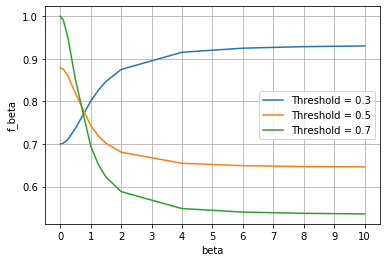

In [9]:

thresholds = [0.3, 0.5, 0.7]
#  beta < 1 lends more weight to precision, while beta > 1 favors precision
betas = [0, 0.1, 0.25, 0.5, 1, 1.25, 1.5, 2, 4, 6, 8, 10]
precision_recall = []

for threshold in thresholds:
    precision = micro_avg_precision(X_test, y_test, all_targeted_class_dict, threshold)
    recall = micro_avg_recall(X_test, y_test, all_targeted_class_dict, threshold)
    f_betas = [f_beta(precision, recall, beta) for beta in betas]
    plt.plot(betas, f_betas, label=f"Threshold = {threshold}")


plt.legend()
plt.grid()
plt.xticks(range(11))
plt.xlabel('beta')
plt.ylabel('f_beta')
plt.show()